Download data of NIKE inc
https://finance.yahoo.com/quote/NKE/history?period1=1535738400&period2=1567274400&interval=1d&filter=history&frequency=1d

In [2]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [3]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 1, 11)

df = web.DataReader("NKE", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-07,76.360001,74.300003,74.739998,75.720001,8184800.0,75.121986
2019-01-08,77.400002,76.199997,76.830002,76.730003,8809000.0,76.124008
2019-01-09,77.150002,76.139999,76.970001,76.589996,8591000.0,75.985107
2019-01-10,77.339996,75.459999,75.639999,76.419998,11148600.0,75.816452
2019-01-11,76.889999,75.800003,76.339996,76.040001,10689900.0,75.439461


In [10]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [15]:
mavg.tail()

Date
2019-01-07    76.543007
2019-01-08    76.513477
2019-01-09    76.488182
2019-01-10    76.456465
2019-01-11    76.423937
Name: Adj Close, dtype: float64

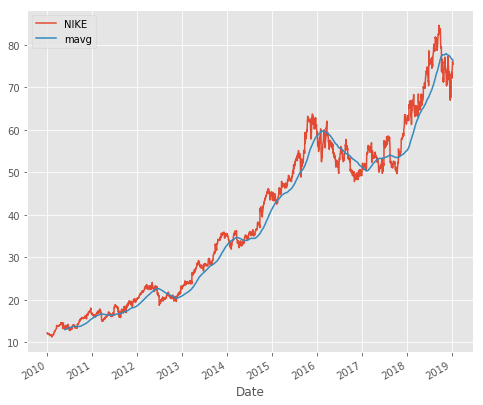

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='NIKE')
mavg.plot(label='mavg')
plt.legend()

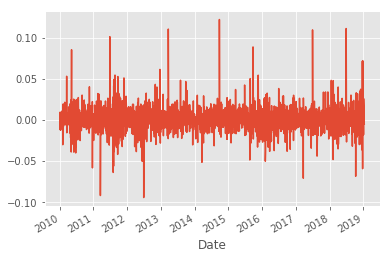

In [16]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [26]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [28]:
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-01-07,75.121986,8184800.0,2.720546,1.311217
2019-01-08,76.124008,8809000.0,1.563931,-0.130156
2019-01-09,75.985107,8591000.0,1.318713,-0.493705
2019-01-10,75.816452,11148600.0,2.460085,1.031199
2019-01-11,75.439461,10689900.0,1.433451,-0.392973


In [32]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [38]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [40]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [41]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [43]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

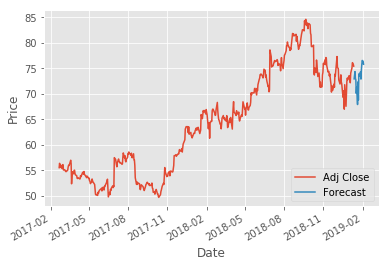

In [44]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [45]:
forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan

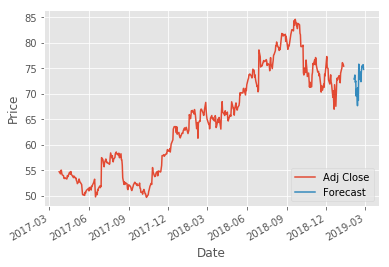

In [46]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [54]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

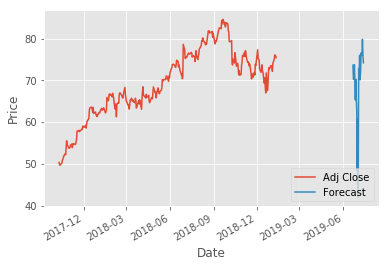

In [55]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()